<a href="https://colab.research.google.com/github/lulyarmida/defensa_consumidor/blob/main/denuncias_defensa_consumidor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install es_core_news_sm

In [ ]:
pip install pyLDAvis

In [4]:
import numpy as np
import random
import pickle
import gzip
import datetime

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

import spacy
from spacy.lang.es.examples import sentences 
import es_core_news_sm

import nltk
from nltk.stem import SnowballStemmer
import gensim
from gensim import corpora
import pickle

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [46]:
df = pd.read_csv('/content/drive/MyDrive/Proyectos/denuncia_caba/denuncias-defensa-del-consumidor.csv', encoding='latin-1', sep=';')

In [ ]:
grouped = df.groupby(['Año','month'])
print(grouped.count())

In [58]:
df.head(20)

,DenunciaID,Año,Fecha_Creacion,Motivo_Denuncia,Rubro,Fecha,Fecha_c,month,Fecha_lag1,diff_days
0,1999,2019,2/1/2019,Garantia de Bienes. Art 11 Ley 24.240 - Falta...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,2/1/2019,2019-01-02,1,NaT,NaN
1,2000,2019,2/1/2019,Falta de cumplimento garantia posventa,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,2/1/2019,2019-01-02,1,2019-01-02,0.0
2,2001,2019,2/1/2019,Practicas Abusivas - Venta Enganosa,"SERVICIOS FINANCIEROS (TARJETAS DE CREDITO, BA...",2/1/2019,2019-01-02,1,2019-01-02,0.0
3,2002,2019,2/1/2019,Garantia de Bienes. Art 11 Ley 24.240 - Repar...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,2/1/2019,2019-01-02,1,2019-01-02,0.0
4,2003,2019,2/1/2019,Garantia de Bienes. Art 11 Ley 24.240 - Repar...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,2/1/2019,2019-01-02,1,2019-01-02,0.0
5,2004,2019,3/1/2019,Problemas de fraude o estafa,"SERVICIOS FINANCIEROS (TARJETAS DE CREDITO, BA...",3/1/2019,2019-01-03,1,2019-01-02,1.0
6,2005,2019,3/1/2019,Falta de Informacion,"RODADOS, AUTOMOTORES Y EMBARCACIONES",3/1/2019,2019-01-03,1,2019-01-03,0.0
7,2006,2019,3/1/2019,Producto no funciona,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,3/1/2019,2019-01-03,1,2019-01-03,0.0
19,2020,2019,4/1/2019,Demora en la entrega del bien,MUEBLES,4/1/2019,2019-01-04,1,2019-01-03,1.0
18,2019,2019,4/1/2019,Incumplimiento de Oferta Promociones y/o Boni...,ALIMENTOS Y BEBIDAS,4/1/2019,2019-01-04,1,2019-01-04,0.0


In [48]:
df['Fecha']=df['Fecha_Creacion'].str[:10]

df['Fecha_c'] =  pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

In [50]:
df['month'] = df['Fecha_c'].dt.month

In [52]:
#hay que ordenar por fecha

# Sort by age in ascending order
df = df.sort_values(by='Fecha_c')

In [53]:
df['Fecha_lag1'] = df['Fecha_c'].shift(1)

In [54]:
#create new columns that contains date differences
df['diff_days'] = (df['Fecha_c'] - df['Fecha_lag1']) / np.timedelta64(1, 'D')
#df['diff_weeks'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'W')
#df['diff_months'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'M')
#df['diff_years'] = (df['end_date'] - df['start_date']) / np.timedelta64(1, 'Y')

In [59]:
nlp=spacy.load('es_core_news_sm')
from spacy.lang.es import Spanish
parser = Spanish()
nltk.download('stopwords')
es_stop = set(nltk.corpus.stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [60]:
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            continue
            #lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [61]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in es_stop]
    tokens = [stemmer.stem(token) for token in tokens]
    return tokens

In [62]:
df['tokens'] = df.apply(lambda x: prepare_text_for_lda(x.Motivo_Denuncia), axis=1)
dictionary = corpora.Dictionary(df['tokens'].values)
df['bow'] = df.apply(lambda x: dictionary.doc2bow(x.tokens), axis=1)
corpus = df['bow'].values

In [63]:
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.8/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sco

In [64]:
def apply_topics(grp):
    topics = ldamodel.get_document_topics(grp['bow'])
    for i in range(len(topics)):
        grp[f'topic_{i}'] = topics[i][1]
    return grp
df = df.apply(apply_topics,axis=1)

In [65]:
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.202*"servici" + 0.192*"prestacion" + 0.167*"contrat" + 0.140*"incumpl" + 0.130*"total" + 0.039*"posvent"')
(1, '0.124*"entreg" + 0.120*"falt" + 0.089*"product" + 0.083*"deficient" + 0.083*"calid" + 0.060*"conven"')
(2, '0.209*"falt" + 0.112*"inform" + 0.104*"entreg" + 0.060*"servici" + 0.043*"document" + 0.042*"pag"')
(3, '0.030*"consorci" + 0.026*"asamble" + 0.025*"libr" + 0.023*"conserv" + 0.022*"segur" + 0.021*"anex"')


0. garantia productos; 1. edificios/consorcios;  2. entrega productos ; 3. incumplimiento servicios

In [66]:
df['tm1']  = np.where(df['topic_0']>=0.60,1,0)
df['tm2']  = np.where(df['topic_1']>=0.60,2,0)
df['tm3']  = np.where(df['topic_2']>=0.60,3,0)
df['tm4']  = np.where(df['topic_3']>=0.60,4,0)
df['tm']  = df['tm1']+df['tm2']+df['tm3']+df['tm4']

In [67]:
#reagrupo la variable tenure en base al decil
conditions2 = [
    (df['tm'] == 1),
    (df['tm'] == 2),
    (df['tm'] == 3),
    (df['tm'] == 4)]
choices2 = ['garantia productos','edificios/consorcios','entrega productos',' incumplimiento servicios']
df['tm_cat'] = np.select(conditions2, choices2, default='Sin clasificar')

In [68]:
df.head(15)

,Año,DenunciaID,Fecha,Fecha_Creacion,Fecha_c,Fecha_lag1,Motivo_Denuncia,Rubro,bow,diff_days,...,topic_0,topic_1,topic_2,topic_3,tm1,tm2,tm3,tm4,tm,tm_cat
0,2019,1999,2/1/2019,2/1/2019,2019-01-02,NaT,Garantia de Bienes. Art 11 Ley 24.240 - Falta...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...",NaN,...,0.281795,0.393811,0.032554,0.291840,0,0,0,0,0,Sin clasificar
1,2019,2000,2/1/2019,2/1/2019,2019-01-02,2019-01-02,Falta de cumplimento garantia posventa,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,"[(3, 1), (4, 1), (7, 1), (8, 1)]",0.0,...,0.649997,0.052640,0.247083,0.050280,1,0,0,0,1,garantia productos
2,2019,2001,2/1/2019,2/1/2019,2019-01-02,2019-01-02,Practicas Abusivas - Venta Enganosa,"SERVICIOS FINANCIEROS (TARJETAS DE CREDITO, BA...","[(9, 1), (10, 1), (11, 1), (12, 1)]",0.0,...,0.050001,0.849997,0.050001,0.050000,0,2,0,0,2,edificios/consorcios
3,2019,2002,2/1/2019,2/1/2019,2019-01-02,2019-01-02,Garantia de Bienes. Art 11 Ley 24.240 - Repar...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,"[(0, 1), (2, 1), (4, 1), (13, 1), (14, 1)]",0.0,...,0.375747,0.041679,0.374088,0.208486,0,0,0,0,0,Sin clasificar
4,2019,2003,2/1/2019,2/1/2019,2019-01-02,2019-01-02,Garantia de Bienes. Art 11 Ley 24.240 - Repar...,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,"[(0, 1), (2, 1), (4, 1), (13, 1), (14, 1)]",0.0,...,0.375747,0.041679,0.374088,0.208486,0,0,0,0,0,Sin clasificar
5,2019,2004,3/1/2019,3/1/2019,2019-01-03,2019-01-02,Problemas de fraude o estafa,"SERVICIOS FINANCIEROS (TARJETAS DE CREDITO, BA...","[(15, 1), (16, 1), (17, 1)]",1.0,...,0.812479,0.062511,0.062507,0.062503,1,0,0,0,1,garantia productos
6,2019,2005,3/1/2019,3/1/2019,2019-01-03,2019-01-03,Falta de Informacion,"RODADOS, AUTOMOTORES Y EMBARCACIONES","[(3, 1), (18, 1)]",0.0,...,0.083334,0.087815,0.384351,0.444500,0,0,0,0,0,Sin clasificar
7,2019,2006,3/1/2019,3/1/2019,2019-01-03,2019-01-03,Producto no funciona,ELECTRODOMESTICOS Y ARTEFACTOS PARA EL HOGAR,"[(19, 1), (20, 1)]",0.0,...,0.083333,0.750000,0.083333,0.083333,0,2,0,0,2,edificios/consorcios
19,2019,2020,4/1/2019,4/1/2019,2019-01-04,2019-01-03,Demora en la entrega del bien,MUEBLES,"[(21, 1), (22, 1)]",1.0,...,0.083333,0.747336,0.085998,0.083333,0,2,0,0,2,edificios/consorcios
18,2019,2019,4/1/2019,4/1/2019,2019-01-04,2019-01-04,Incumplimiento de Oferta Promociones y/o Boni...,ALIMENTOS Y BEBIDAS,"[(9, 1), (17, 1), (23, 1), (24, 1), (25, 2), (...",0.0,...,0.883071,0.083592,0.016670,0.016668,1,0,0,0,1,garantia productos


In [69]:
def normalize(s):
    replacements = (
        (",", ""),
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

In [70]:
df['Rubro_n'] = df['Rubro'].map(lambda x: normalize( x))
df['Motivo_Denuncia_n'] = df['Motivo_Denuncia'].map(lambda x: normalize( x))

In [ ]:
pivot_table = pd.pivot_table(df, index=['Rubro_n'] ,columns=['tm_cat'], values= 'DenunciaID' , aggfunc=['count'])
pivot_table

In [71]:
df.to_csv('/content/drive/MyDrive/Proyectos/denuncia_caba/data_denuncia_tm.csv')

In [72]:
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

AttributeError: ignored

## esto se hizo en formato prueba

In [ ]:
nltk.download('stopwords')
es_stop = set(nltk.corpus.stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

pivot_table = pd.pivot_table(df, index=['Rubro_n','Año'], values='DenunciaID', aggfunc='count')
pt_sorted =pivot_table.sort_values(by=['Rubro_n','Año'], ascending=False)
pt_sorted.head(20)

In [ ]:
# Remove the columns
text = df.drop(columns=['DenunciaID', 'Año', 'Fecha_Creacion'], axis=1)
# Print out the first rows of papers
text.head()

https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [ ]:
# Load the regular expression library
import re
# Remove punctuation
text['Motivo_Denuncia_processed'] =text['Motivo_Denuncia_n'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
text['Motivo_Denuncia_processed'] =text['Motivo_Denuncia_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
text['Motivo_Denuncia_processed'].head()

In [ ]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('spanish')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
text['Motivo_Denuncia_ssw'] = text['Motivo_Denuncia_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


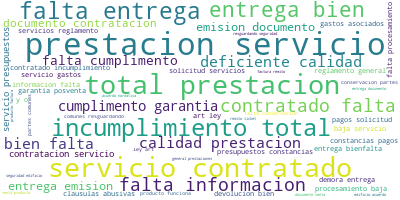

In [ ]:
b# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(text['Motivo_Denuncia_ssw'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('spanish')
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = text.Motivo_Denuncia_ssw.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['garantia', 'bienes', 'art', 'ley', 'falta', 'suministro', 'partes', 'accesorios']


In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]


In [ ]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
#no lo estoy usando
# Process whole documents
text = ("Cumplimiento parcial o defectuoso de la prestacion del servicio - Falta de o conectividad deficiente "
        "Precios - Precio excesivo "
        "Incumplimiento de Oferta  Promociones y/o Bonificaciones.  Art. 7 de la Ley 24.240 ")
doc = nlp(text)

# Analyze syntax
print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])

# Find named entities, phrases and concepts
for entity in doc.ents:
    print(entity.text, entity.label_)

Noun phrases: ['Cumplimiento', 'la prestacion', 'servicio', 'Falta', 'conectividad', 'Precios', 'Precio', 'Incumplimiento de Oferta  Promociones', 'Bonificaciones', 'Art', 'la Ley']
Verbs: []
Falta LOC
Precios - Precio excesivo Incumplimiento de Oferta  Promociones MISC
Bonificaciones LOC
la Ley LOC
